<a href="https://www.kaggle.com/code/davidhavrilenko/detect-hotdogs?scriptVersionId=111170105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import shap

In [2]:
# Load data
train_ds = image_dataset_from_directory(
    '../input/hotdog-nothotdog/hotdog-nothotdog/hotdog-nothotdog/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
valid_ds = image_dataset_from_directory(
    '../input/hotdog-nothotdog/hotdog-nothotdog/hotdog-nothotdog/test',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)

Found 4242 files belonging to 2 classes.


2022-11-16 11:21:45.817886: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 400 files belonging to 2 classes.


In [3]:
# Converting data to float
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
valid_ds = (
    valid_ds
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [4]:
# Load pretrained model Xception
pretrained_model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=[128,128,3],
)
pretrained_model.trainable = False

83697664/83683744 [==============================] - 3s 0us/step


In [5]:
model = keras.Sequential([
    # Preprocessing images
    pretrained_model,
    
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 20,992,937
Trainable params: 131,329
Non-trainable params: 20,861,608
______________________________________

In [6]:
model.compile(optimizer = 'adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [7]:
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=4,
    shuffle=True,
)

Epoch 1/4


2022-11-16 11:21:51.596981: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


67/67 [==============================] - 113s 2s/step - loss: 0.3606 - accuracy: 0.8510 - val_loss: 0.5519 - val_accuracy: 0.7450
Epoch 2/4
67/67 [==============================] - 102s 2s/step - loss: 0.2505 - accuracy: 0.8951 - val_loss: 0.4005 - val_accuracy: 0.8275
Epoch 3/4
67/67 [==============================] - 102s 2s/step - loss: 0.2169 - accuracy: 0.9151 - val_loss: 0.3520 - val_accuracy: 0.8525
Epoch 4/4
67/67 [==============================] - 102s 2s/step - loss: 0.1837 - accuracy: 0.9276 - val_loss: 0.3745 - val_accuracy: 0.8375


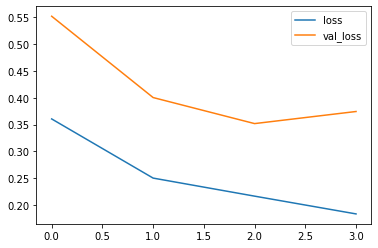

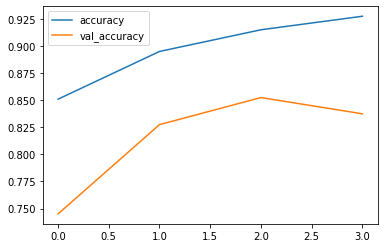

In [8]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();